## SABR Model Calibration of Volatility Smiles

SABR Model specification
\begin{align}
d\hat{F}=\hat{α}\hat{F}^βdW_1 \ , \hat{F}(0)=f \\
d\hat{α}=ν \hat{α}dW_2 \ , \hat{α}(0)=α \\
\end{align}

Approximation of the Black's implied volatility as a function of the SABR parameters:


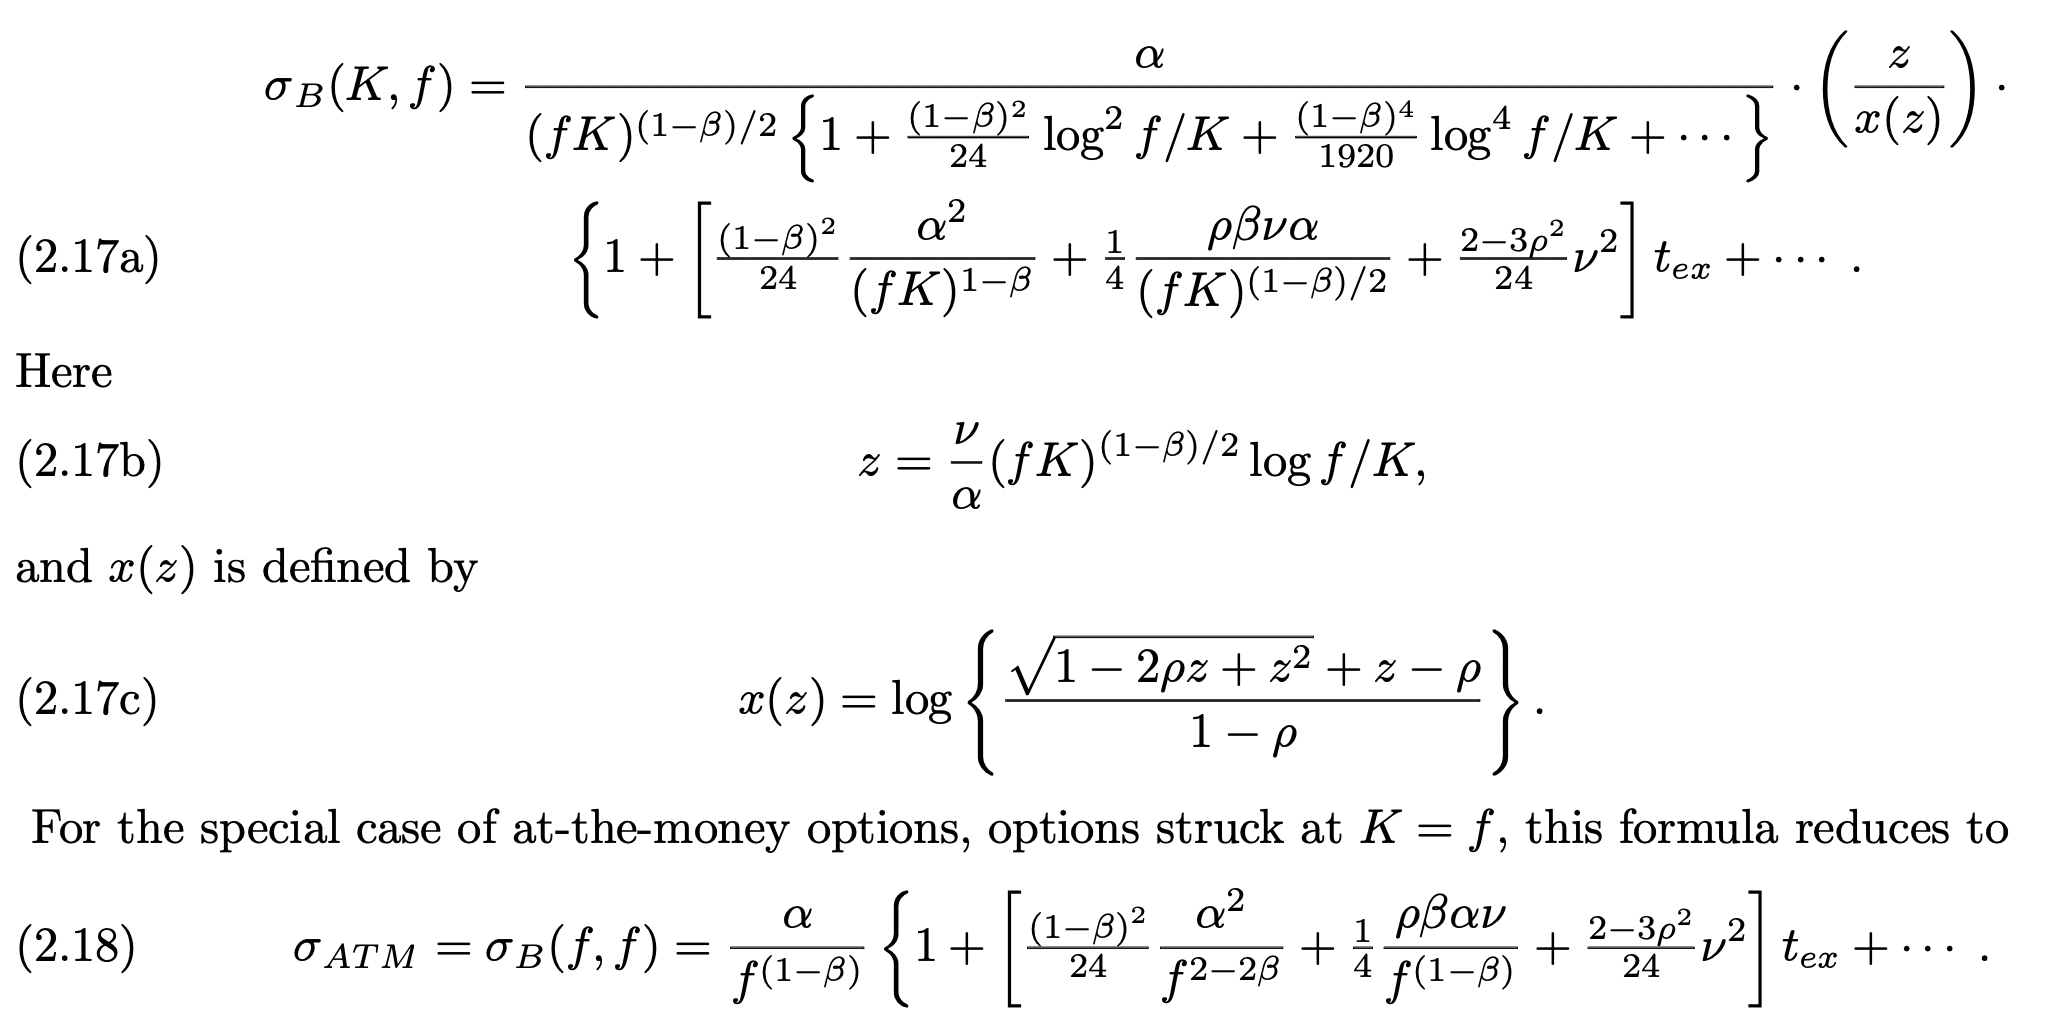

Key Ideas


*   Set Beta =0.5 (the stochastic CIR model)
*   Use numerical method to minimize **(market implied vol - SABR vol)^2** to get Alpha, Rho, Volvol
*   Calculate SABR vol for each strike given optimized Alpha, Rho and Volvol
*   Compare SABR calibrated vol with the market implied vol to identify the outliers.  Long the most undervalued and short the most overvalued












# SABR Calibration Core Functions

In [4]:
import pandas as pd
import pysabr
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr

In [5]:
def calc_sabr_vol(df,spot,r,beta=0.5,plot=True):
  '''
  Calculate sabr vol for a Dataframe of options given spot and r level
  input fields:
  ['option_type','days_to_expiry','strike','ivol']
  return fields:
  ['option_type','days_to_expiry','strike','ivol','sabr_vol','residual']
  '''
  df['sabr_vol']=0
  for cp,d in itertools.product(df.option_type.unique(), df.days_to_expiry.unique()):
    tem=df.loc[(df.option_type==cp) & (df.days_to_expiry==d)]
    f = spot * math.exp(r * d/365)
    sabr = Hagan2002LognormalSABR(f=f, t=d, beta=beta)
    [alpha, rho, volvol] = sabr.fit(tem['strike'].to_numpy(), tem['ivol'].to_numpy())
    df['sabr_vol']=df.apply(lambda row : hagan_2002_lognormal_sabr.lognormal_vol(row.strike, f, d, alpha, beta, rho, volvol)*100
                            if row.option_type==cp and row.days_to_expiry==d else row.sabr_vol, axis=1)
    df['residual']=(df.ivol-df.sabr_vol)/df.sabr_vol
  if plot:
    _plot_sabr(df)
  return df

def _plot_sabr(df):
  for cp,d in itertools.product(df.option_type.unique(), df.days_to_expiry.unique()):
    print(cp,d)
    tem=df.loc[(df.option_type==cp) & (df.days_to_expiry==d)]
    plt.plot(tem.strike,tem.sabr_vol)
    plt.plot(tem.strike, tem.ivol, 'bo')
    plt.title(f"SABR model calibration of volatility smiles, Option Type: {cp}, Days to Expiry: {d}")
    plt.xlabel("Strike")
    plt.ylabel("sabr_vol")
    plt.show()

# Apply to HSI Index Options

call 16


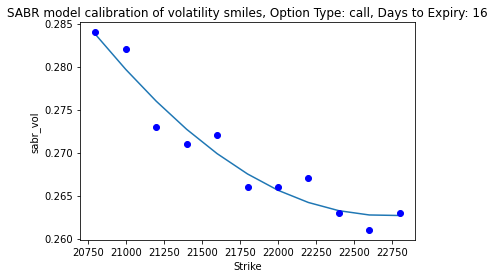

put 16


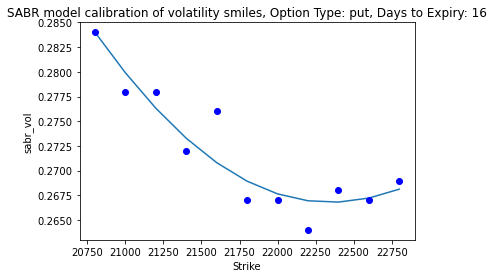

In [6]:
# data from https://www.hkex.com.hk/Products/Listed-Derivatives/Equity-Index/Hang-Seng-Index-(HSI)/Hang-Seng-Index-Options?sc_lang=en#&product=HSI
df=pd.DataFrame([{'days_to_expiry': 16, 'ivol': 0.284, 'option_type': 'call', 'strike': 20800},
 {'days_to_expiry': 16, 'ivol': 0.282, 'option_type': 'call', 'strike': 21000},
 {'days_to_expiry': 16, 'ivol': 0.273, 'option_type': 'call', 'strike': 21200},
 {'days_to_expiry': 16, 'ivol': 0.271, 'option_type': 'call', 'strike': 21400},
 {'days_to_expiry': 16, 'ivol': 0.272, 'option_type': 'call', 'strike': 21600},
 {'days_to_expiry': 16, 'ivol': 0.266, 'option_type': 'call', 'strike': 21800},
 {'days_to_expiry': 16, 'ivol': 0.266, 'option_type': 'call', 'strike': 22000},
 {'days_to_expiry': 16, 'ivol': 0.267, 'option_type': 'call', 'strike': 22200},
 {'days_to_expiry': 16, 'ivol': 0.263, 'option_type': 'call', 'strike': 22400},
 {'days_to_expiry': 16, 'ivol': 0.261, 'option_type': 'call', 'strike': 22600},
 {'days_to_expiry': 16, 'ivol': 0.263, 'option_type': 'call', 'strike': 22800},
 {'days_to_expiry': 16, 'ivol': 0.284, 'option_type': 'put', 'strike': 20800},
 {'days_to_expiry': 16, 'ivol': 0.278, 'option_type': 'put', 'strike': 21000},
 {'days_to_expiry': 16, 'ivol': 0.278, 'option_type': 'put', 'strike': 21200},
 {'days_to_expiry': 16, 'ivol': 0.272, 'option_type': 'put', 'strike': 21400},
 {'days_to_expiry': 16, 'ivol': 0.276, 'option_type': 'put', 'strike': 21600},
 {'days_to_expiry': 16, 'ivol': 0.267, 'option_type': 'put', 'strike': 21800},
 {'days_to_expiry': 16, 'ivol': 0.267, 'option_type': 'put', 'strike': 22000},
 {'days_to_expiry': 16, 'ivol': 0.264, 'option_type': 'put', 'strike': 22200},
 {'days_to_expiry': 16, 'ivol': 0.268, 'option_type': 'put', 'strike': 22400},
 {'days_to_expiry': 16, 'ivol': 0.267, 'option_type': 'put', 'strike': 22600},
 {'days_to_expiry': 16, 'ivol': 0.269, 'option_type': 'put', 'strike': 22800}])

spot = 21512.45
r = 0.0015
df=calc_sabr_vol(df,spot,r)


# Trading Strategy

